Conditional Variational Autoencoder (CVAE) extends the standard Variational Autoencoder (VAE) by incorporating additional conditioning information to influence the latent space and generation process. Here’s how they differ:

1. **Latent Space Conditioning**:  
   - **VAE**: Learns an unsupervised latent representation from input data without external control.  
   - **CVAE**: Uses additional conditioning variables (e.g., class labels, attributes) to guide the latent space, allowing for controlled generation.

2. **Input to Encoder & Decoder**:  
   - **VAE**: The encoder takes only the input \( x \) and maps it to a latent distribution \( q(z|x) \). The decoder reconstructs \( x \) from the latent variable \( z \).  
   - **CVAE**: Both the encoder and decoder receive the conditioning variable \( c \) along with \( x \). The latent distribution is now modeled as \( q(z|x, c) \), and the decoder reconstructs \( x \) as \( p(x|z, c) \).

3. **Loss Function**:  
   - Both VAEs and CVAEs use the **Evidence Lower Bound (ELBO)**, but CVAE conditions the likelihood and KL divergence on $ c $:  
     $
     \mathcal{L} = \mathbb{E}_{q(z|x,c)}[\log p(x|z,c)] - D_{\text{KL}}(q(z|x,c) \parallel p(z|c))
     $

4. **Use Case**:  
   - **VAE**: Best suited for unsupervised representation learning and general data generation.  
   - **CVAE**: Useful when we want controlled generation (e.g., generating images of digits conditioned on digit labels).

### Example:  
- **VAE**: Generate diverse handwritten digits without control.  
- **CVAE**: Generate a specific digit (e.g., "7") by conditioning the model on the digit class.

Would you like a code example?

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from keras.datasets import mnist, fashion_mnist

2025-03-08 06:03:44.346779: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 06:03:44.522234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741413824.665629      21 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741413824.712626      21 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 06:03:45.051234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appro

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
x_train = x_train.astype("float32")/255.0

x_test = x_test.astype("float32")/255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
x_train = torch.tensor(x_train).unsqueeze(1) # adding an extra dimension at 1st index, as channel dimension

x_test = torch.tensor(x_test).unsqueeze(1)

In [5]:
y_train = F.one_hot(torch.tensor(y_train).long()).type(torch.float32)
y_test = F.one_hot(torch.tensor(y_test).long()).type(torch.float32)

In [6]:
train = []
for i in range(len(x_train)):
    train.append([x_train[i], y_train[i]])    
    
test = []
for i in range(len(x_test)):
    test.append([x_test[i], y_test[i]])

In [7]:
train_dl = torch.utils.data.DataLoader(train,batch_size=60,shuffle=True)
val_dl = torch.utils.data.DataLoader(test,batch_size=60,shuffle=True)

In [8]:
latent_dim = 128
num_classes = 10
in_channels = 1
img_size = 28

In [45]:
# Defining Autoencoder model
class ConditionalVAE(nn.Module):
    
    def __init__(self, ):
        super(ConditionalVAE, self).__init__()
        self.encoder = nn.Sequential(
               nn.Conv2d(2,32,3,padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2,2),
               nn.Conv2d(32,16,3,padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2,2),
               nn.Conv2d(16,8,3,padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2,2),
           )
        self.decoder = nn.Sequential(
           nn.ConvTranspose2d(8,8,3,stride=2),
           nn.ReLU(),
           nn.ConvTranspose2d(8,16,2,stride=2),
           nn.ReLU(),
           nn.ConvTranspose2d(16,32,2,stride=2),
           nn.ReLU(),
           nn.Conv2d(32,1,3,padding=1),
           nn.Sigmoid(),
       )
        
        self.fc_mu = nn.Linear(8*9, latent_dim)
        self.fc_var = nn.Linear(8*9, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim+num_classes, 8*9)
        
        self.embed_class = nn.Linear(num_classes, img_size * img_size)
        self.embed_data = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def forward(self, x, y):
        
        y_embed = self.embed_class(y)
        y_embed = y_embed.view(-1, img_size, img_size).unsqueeze(1)
        x_embed = self.embed_data(x)
        x_enc_inp = torch.cat([x_embed, y_embed], dim = 1)
        encoded = self.encoder(x_enc_inp)
        result = torch.flatten(encoded, start_dim=1)
        
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        
        z = self.reparameterize(mu, log_var)
        z = torch.cat([z, y], dim = 1)
        decoded = self.decoder_input(z)
        decoded = decoded.view(-1,8,3,3)
        x_ = self.decoder(decoded)
        return  [x_, x, mu, log_var]

In [46]:
def loss_function(recons, input_, mu, log_var):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """

        kld_weight = 0.00025 #kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input_)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return loss

In [47]:
# Setting random seed for reproducibility
torch.manual_seed(30)
model = ConditionalVAE()

In [48]:
model = model.to("cuda")

In [49]:
num_epochs = 1
criterion = loss_function
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.002,steps_per_epoch=len(train_dl),epochs=num_epochs)

In [50]:
# Training the autoencoder
for epoch in range(num_epochs):
    model.train()
    trl = 0
    for bat in train_dl:
        x_train_data = bat[0].to("cuda")
        y_train_data = bat[1].to("cuda")
        
        # Forward pass
        recons, input_, mu, log_var = model(x_train_data, y_train_data)
        loss = criterion(recons, input_, mu, log_var)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        sched.step()
        trl += loss.item()
        
    model.eval()
    vl = 0
    with torch.no_grad():
        for bat_val in val_dl:
            x_val_data = bat_val[0].to("cuda")
            y_val_data = bat_val[1].to("cuda")
            
            recons, input_, mu, log_var = model(x_val_data, y_val_data)
            val_loss = criterion(recons, input_, mu, log_var)
            vl += val_loss.item()

    # Loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {trl/len(train_dl):.4f}, Val_Loss: {vl/len(val_dl):.4f}')

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torc

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torc

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size(

torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ torch.Size([60, 1, 28, 28])
torch.Size([60, 2, 28, 28]) ^^^^^^^^^^^^
torch.Size([60, 128]) %%%%%%%%%%%%%%%
torch.Size([60, 138]) $$$$$$$$$$$$$
torch.Size([60, 10]) torch.Size([60, 784]) ############
torch.Size([60, 1, 28, 28]) *********
torch.Size([60, 1, 28, 28]) @@@@@@@@@@ tor

In [18]:
z = torch.randn(1, latent_dim).to("cuda")
y = F.one_hot(torch.tensor([2]).long(),num_classes=10).type(torch.float32).to("cuda")
z = torch.cat([z, y], dim=1)

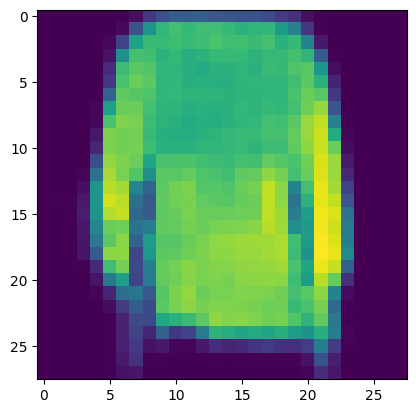

In [19]:
decoded = model.decoder_input(z)
decoded = decoded.view(-1,8,3,3)
x_ = model.decoder(decoded).to("cuda").detach().cpu()

plt.imshow(x_[0].reshape(28,28))